# Quant Research Assignment
- By: Harkishan Singh Baniya
- Email: harkishansinghbaniya@gmail.com

This research notebook is for understanding Nifty and Bank Nifty indices volatilities as they have significant overlap in terms of their constituents and weights. The objective is exploit the dispersion in their volatilites as they are likely to be affected by similar market conditions and macroeconomic factors. Pairs trading strategies are constructed in the attempts to capture any dispersion that may occur between the volatilities of the two indices. <br><br>
The analysis will be performed on minute level historical data of implied volatilities (IVs) of Bank Nifty and Niftyfrom Jan 1st 2021 to Jun 30th 2022. 

In [1]:
import numpy as np # numerical computation
import pandas as pd # data manipulation

from matplotlib import style # asthetics
import matplotlib.pyplot as plt # vizualiation
plt.style.use('seaborn-v0_8-ticks')

from algo import VectorizedBT # Vectorized Backtester Parent Class
from algo import Optimizer # for optimizing a trading strategy

### Reading the dataset provided
The data is provide as a parquet file and I have used pandas with default parquet engine. 

In [2]:
df = pd.read_parquet('data.parquet')
df.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [3]:
df.isna().sum()# check for missing values

banknifty    1500
nifty        2000
tte             0
dtype: int64

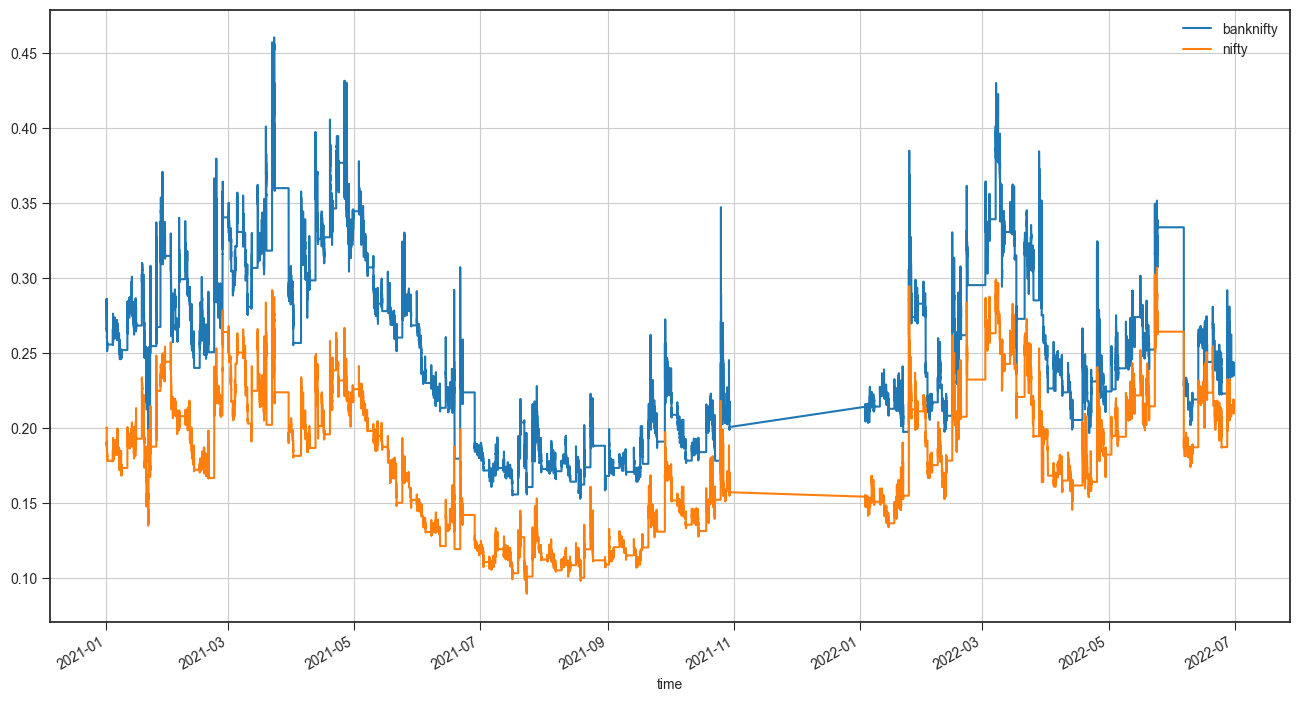

In [4]:
df = df.fillna(method='ffill') # impute the missing values
# plot banknifty and nifty IVs
df[['banknifty', 'nifty']].plot(figsize=(16,9), grid=True);

### Computing the spread
It is simply the difference between the two IVs, given as - <br><br>
$$
\text{Spread} = \text{Bank Nifty IV} - \text{Nifty IV}$$

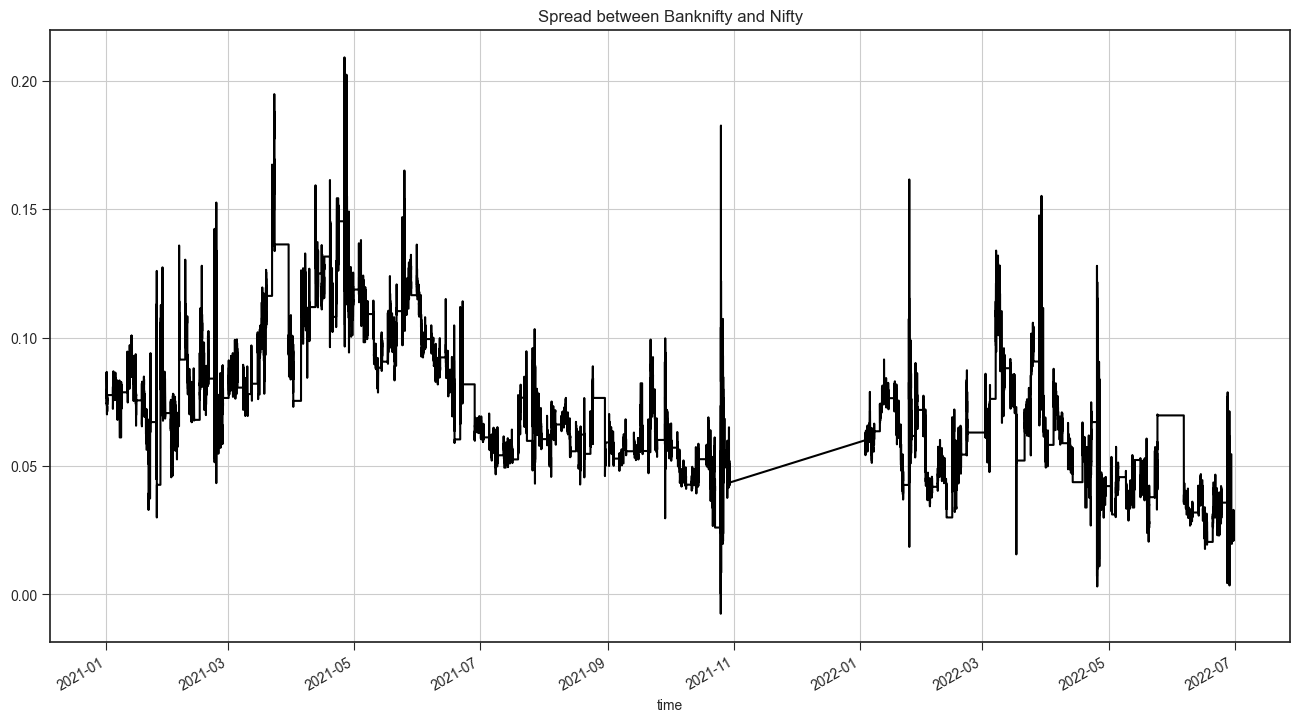

In [5]:
spread = df['banknifty'] - df['nifty']
spread.name = 'spread'
spread.plot(figsize=(16,9), color='black', grid=True, title='Spread between Banknifty and Nifty');

### Adjusting the spread for time decay
Since implied volitility decays with time to expiry we need to adjust the spread between IVs with time to expiry (TTE) as follows - <br><br>
$$
\text{P/L} = \text{Spread} \times (\text{Time To Expiry})^{0.7}$$

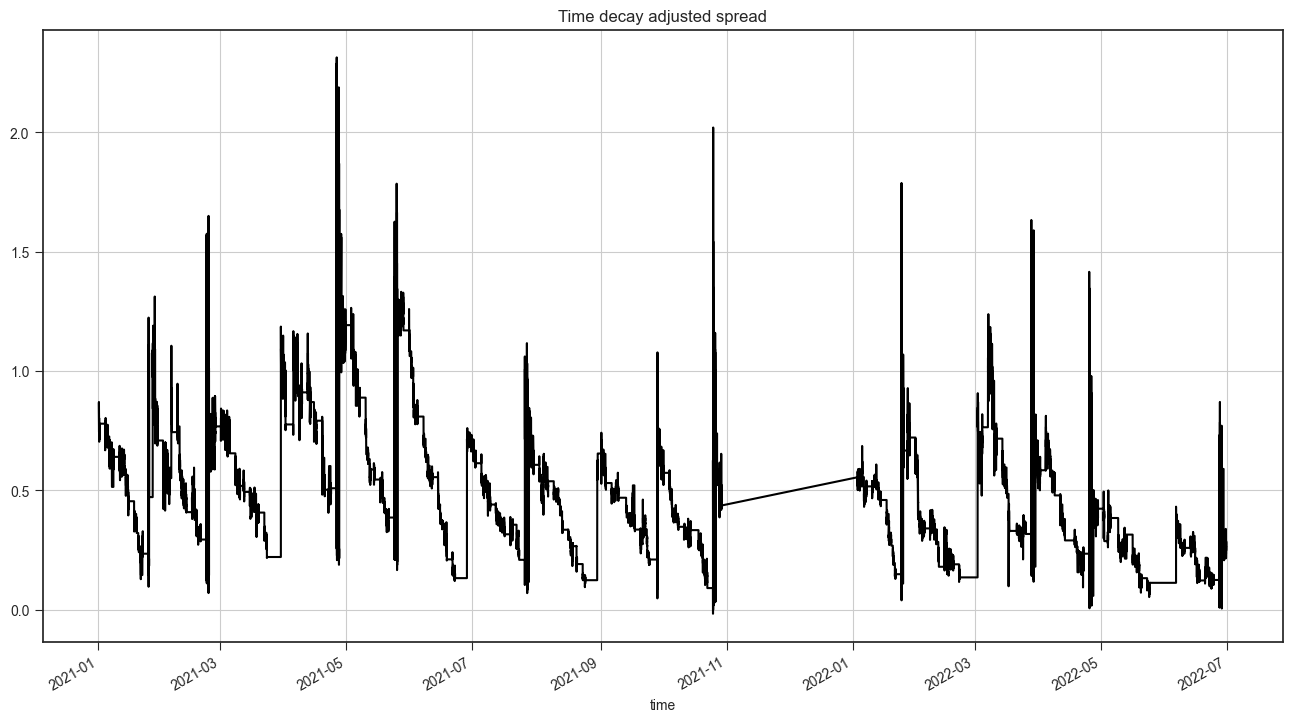

In [6]:
PL = spread*(df['tte']**0.7)
PL.name = 'PL'
PL.plot(figsize=(16,9), color='black', grid=True, title='Time decay adjusted spread');

### Spliting data for in-sample and out-of-sample analysis

In [10]:
offset = pd.Timedelta('255D') # 1 year of insample data
start = df.index[0] # starting date of the dataset
ins, oos = df[:start+offset], df[start+offset:] #insample and out of sample split respectively

## Base Strategy : Z-Score based trading system
A z-score-based pairs trading strategy involves identifying pairs of assets with historically co-moving prices and calculating the z-score of the spread between their prices. The z-score quantifies how far the current spread is from its historical average in terms of standard deviations. Traders typically enter a long position when the z-score is below a threshold $\gamma$ (indicating the spread is below its average) and a short position when it's above the threshold $\gamma$. The strategy aims to capitalize on mean-reverting behavior, as extreme spreads are expected to revert to their historical averages over time. <br><br>
z-score is calculated as - 
$$z = \frac{x-\mu}{\sigma}$$
where, <br>$x = \text{Spread}$<br>
$\mu = \text{Mean Spread}$<br>
$\sigma = \text{Standard Deviation of Spread}$<br>

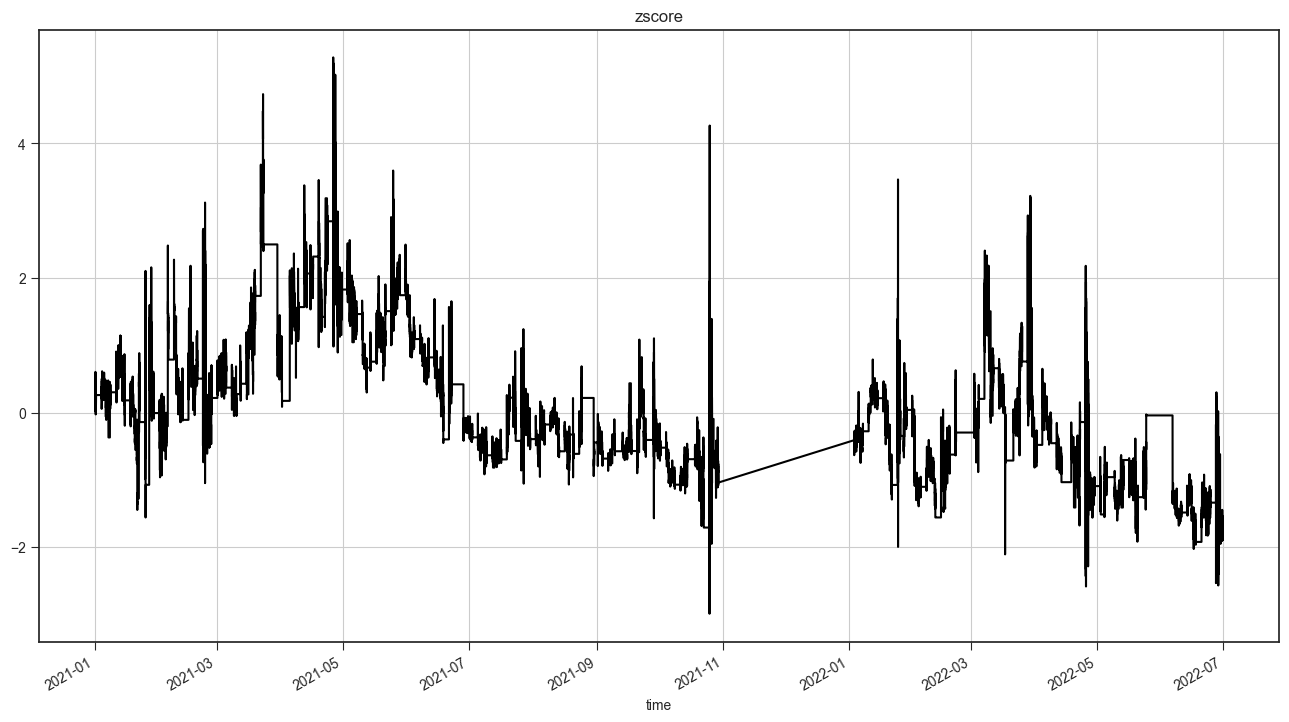

In [11]:
zscore = (spread - spread.mean()) / np.std(spread)
zscore.plot(figsize=(16,9), color='black', grid=True, title='zscore');

### Strategy Implementation
- Compute a moving average ($\mu_n$) of length $n$ (`window size`) on the spread.
- Compute a moving standard deviation($\sigma_n$) of length $n$ (`window size`) on the spread.
- Get the rolling zscore as $z = \frac{\text{Spread}-\mu_n}{\sigma_n}$

<br>

#### Trading Rules : 
- Go Long : $z < -\gamma$<br>
- Go Short : $z > \gamma$<br>
- Exit Long : $z > 0$<br>
- Exit Short : $z < 0$<br>

In [22]:
class ZScoreStrategy(VectorizedBT):
    """
    Z-Score based strategy implementation 
    as vectorized backtesting.
    """
    def __init__(self, df, window_size=30, 
                 entry_level=2, exit_level=0):
        # initialized the VecotrizedBT class
        super(ZScoreStrategy, self).__init__()
        # define the spread
        self.spread = df['banknifty'] - df['nifty']
        # get the decay adjusted spread
        self.PL = self.spread*(df['tte']**0.7)
        # define window size
        self.window = window_size
        # compute the moving average
        mavg = self.spread.rolling(self.window).mean()
        # compute the moving standard deviation
        std = self.spread.rolling(self.window).mean().std()
        # get the rolling score
        self.rolling_zscore = ((self.spread - mavg)/std).dropna()
        # define the thresholds
        self.entry_level = entry_level
        self.exit_level = exit_level
        
    def get_signals(self)->pd.Series:
        """
        Returns the signals from z-score strategy.
        """
        # convert to numpy array for faster computation
        zscore = np.asarray(self.rolling_zscore)
        # get indices for long and short positions
        longs_entry = zscore < -self.entry_level
        longs_exit = zscore > -self.exit_level
        shorts_entry = zscore > self.entry_level
        shorts_exit = zscore < self.exit_level
        # pandas series for storing long short signals
        num_units_long = pd.Series([np.nan for i in range(len(zscore))])
        num_units_short = pd.Series([np.nan for i in range(len(zscore))])
        # set threshold crossings with corresponding position
        num_units_long[longs_entry] = 1.
        num_units_long[longs_exit] = 0
        num_units_short[shorts_entry] = -1.
        num_units_short[shorts_exit] = 0
        # shift to simulate entry delay (of 1 min) in real life trading
        num_units_long = num_units_long.shift(1)
        num_units_short = num_units_short.shift(1)
        # initialize market position with zero
        num_units_long[0] = 0.
        num_units_short[0] = 0.
        # finally, fill in between
        num_units_long = num_units_long.fillna(method='ffill')
        num_units_short = num_units_short.fillna(method='ffill')
        num_units = num_units_long + num_units_short
        # signals series
        signals = pd.Series(0, index=self.spread.index, name='signals')
        signals[self.rolling_zscore.index] = num_units
        return signals

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :                91.73
      Sharpe Ratio :                 3.76
  Max. Drawdown P&L:                -1.69


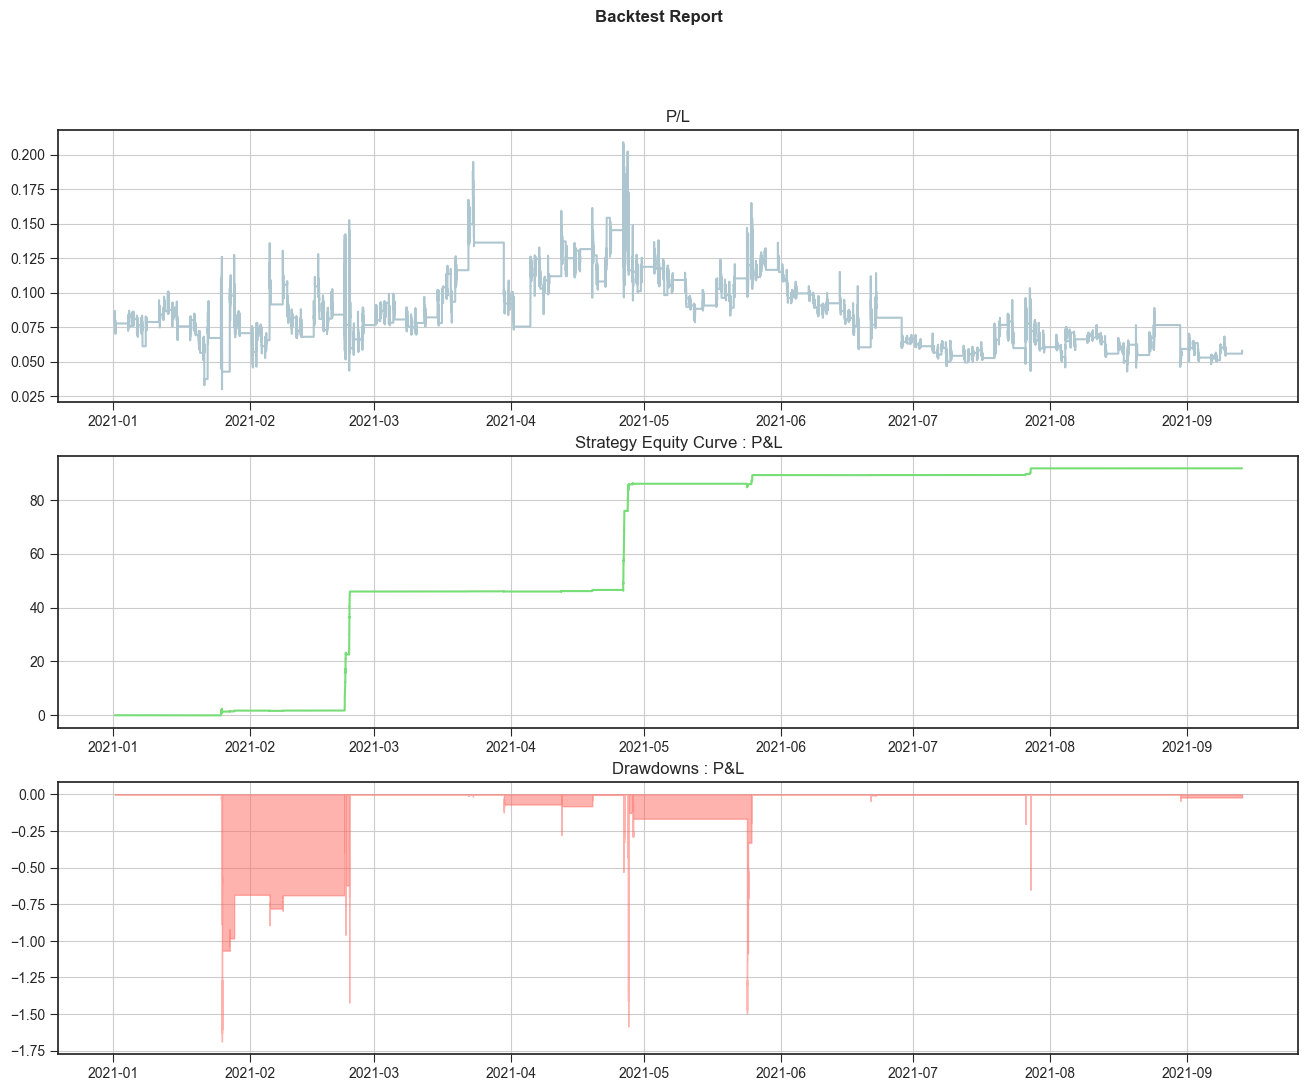

In [23]:
# initialize the backtest
strat = ZScoreStrategy(ins, 30, entry_level=1, exit_level=0)
# run the backtest
strat.run()
# get the backtest summary
strat.get_summary()

## Optimizing Z-Score based Trading System

In [24]:
# In-sample optimization
opt = Optimizer(ZScoreStrategy, ins) # initialize the optimizer with ZScoreStrategy
# search paramters
params = {'entry_level':[1,1.25,1.69,2], 'exit_level':{0,0.5}}
# run search
opt.search(params)

  0%|          | 0/8 [00:00<?, ?it/s]

Best sharpe score achived : 3.959467474023298

Best parameters for the above score : {'entry_level': 1, 'exit_level': 0.5}


#### Out of Sample performance

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :               161.28
      Sharpe Ratio :                 6.64
  Max. Drawdown P&L:                -1.94


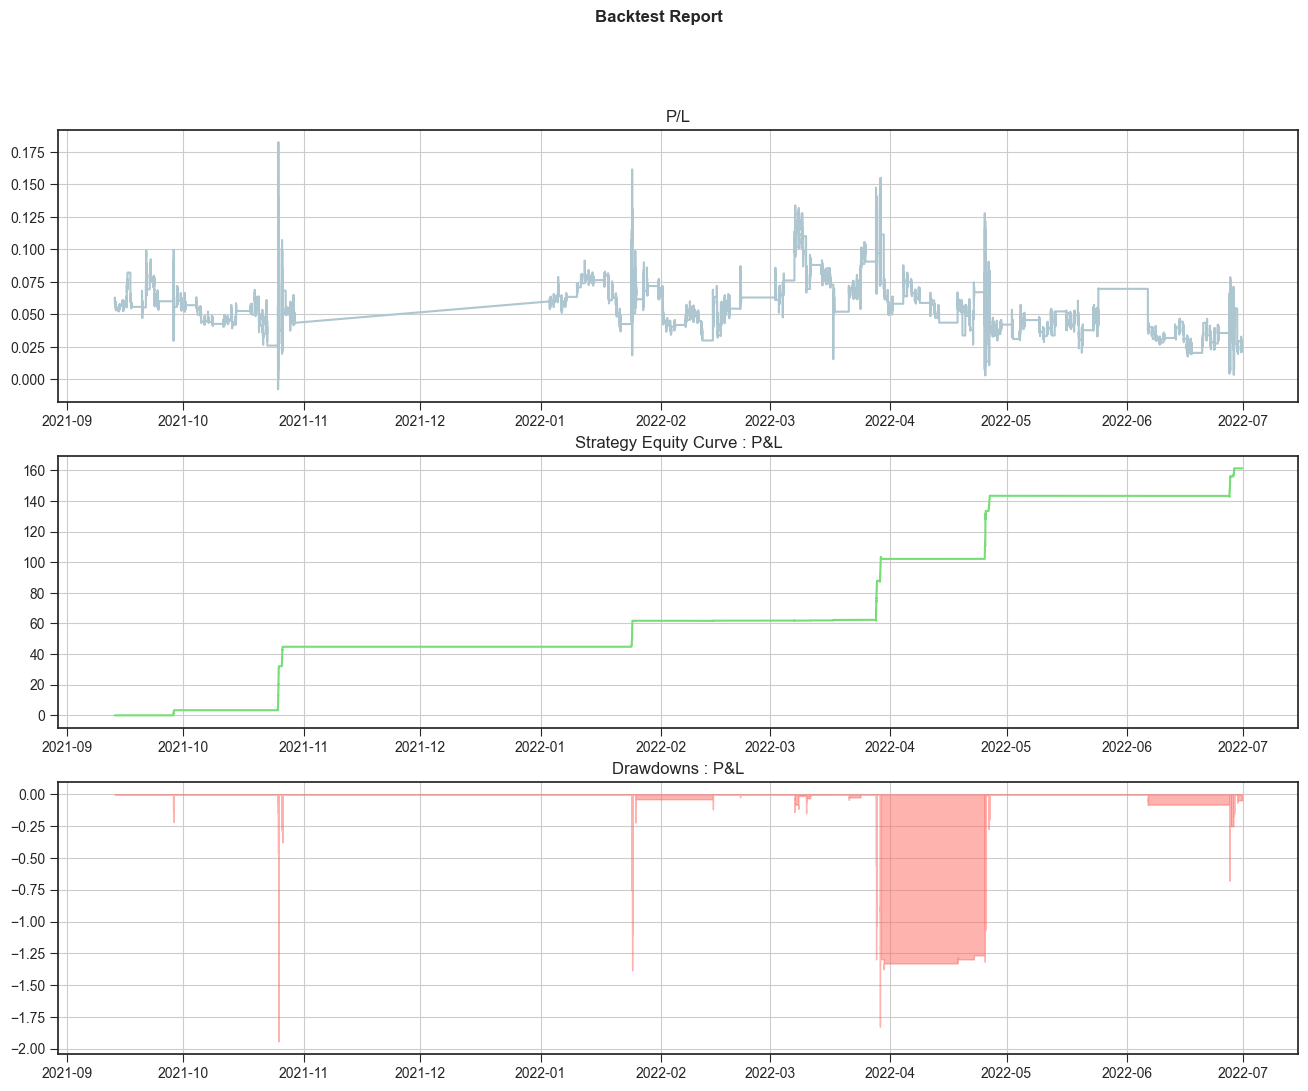

In [25]:
# initialize the backtest
strat = ZScoreStrategy(oos, 30, entry_level=1, exit_level=0.5)
# run the backtest
strat.run()
# get the backtest summary
strat.get_summary()

## Improved Strategy : Quintile based trading system

Let the spread change at $t$ be defined as - $$\Delta x_{t+1} = x_{t+1} - x_t$$
From the distribution $f(\Delta x)$, the set of negative (negative changes) and
positive (positive changes) values are considered separately, originating
the distributions $f^-(\Delta x)$  and $f^+(\Delta x)$,
respectively. <br> <br> The proposed model targets abrupt changes but also requires that they occur
frequently enough, looking for the extreme quantiles seems adequate. As quantiles*
adapt to the spread volatility, the thresholds will ultimately be linked to the spread’s
properties.
<br>
<br>
\**A quintile is any of the four values that divide the sorted data into five equal parts,
so that each part represents 15 of the sample or population. It takes any of the values
$Q_{\Delta x}(0.20)$, $Q_{\Delta x}(0.40)$, . . . , $Q_{\Delta x}(0.80)$.*

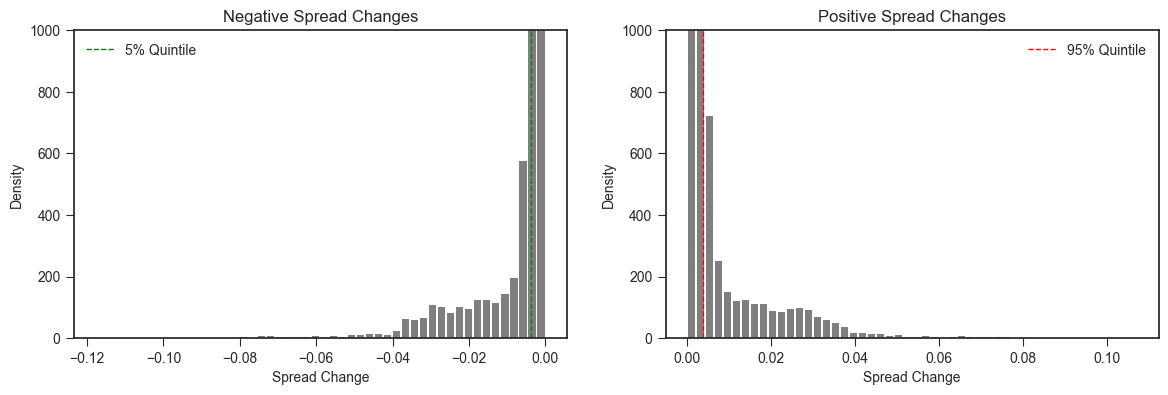

In [26]:
# compute the spread changes
spread_change = spread.diff()[1:]
# postive changes
positive_spread_change = spread_change[spread_change > 0]
# negative changes
negative_spread_change = spread_change[spread_change < 0]
# get the short threshold
short_threshold = positive_spread_change.quantile(q=0.95, interpolation='linear')
# get the long threshold postive changes
long_threshold = negative_spread_change.quantile(q=0.05, interpolation='linear')
# create subplots 
fig, axs = plt.subplots(1,2, figsize=(14, 4))
#plot the positive changes
axs[1].hist(x=np.asarray(positive_spread_change.values), 
            bins=50, align='mid', rwidth=0.8, color='k', alpha=0.5)
axs[1].axvline(x=short_threshold, color='red', linestyle='--', linewidth=1, label='95% Quintile')
axs[1].set_title('Positive Spread Changes')
axs[1].set(xlabel='Spread Change', ylabel='Density')
axs[1].set_ylim((0, 1000))  
axs[1].legend()
#plot the negative changes
axs[0].hist(x=np.asarray(negative_spread_change.values),
            bins=50, align='mid', rwidth=0.8, color='k', alpha=0.5)
axs[0].axvline(x=long_threshold, color='green', linestyle='--', linewidth=1, label='5% Quintile')
axs[0].set_title('Negative Spread Changes')
axs[0].set(xlabel='Spread Change', ylabel='Density')
axs[0].set_ylim((0, 1000))  
axs[0].legend()
#
plt.show()

### Strategy Implementation 
- Compute the rolling upper quintile $\alpha_S$ on adjusted spread of length $n$.
- Compute the rolling lower quintile $\alpha_L$ on adjusted spread of length $n$.
- Compute the rolling 50th %tile $\epsilon$ on adjusted spread of length $n$.

<br>

#### Trading Rules : 
For adjusted spread $x_t$ <br>
- Go Long : $x_t < \alpha_L $<br>
- Go Short : $x_t > \alpha_S $<br>
- Exit Long : $x_t > \epsilon $<br>
- Exit Short : $x_t < \epsilon$<br>

In [27]:
class QuintileStrategy(VectorizedBT):
    """
    An implementation of Quintile based 
    pairs trading strategy. 
    """
    def __init__(self, df, window_size=30, 
                 higher_quintile=0.9, 
                 lower_quintile=0.1):
        super(QuintileStrategy, self).__init__()
        self.spread = df['banknifty'] - df['nifty']
        self.PL = self.spread*(df['tte']**0.7)
        self.window = window_size
        self.thres = df.copy()
        self.thres['PL'] = self.PL
        self.thres['diff'] = self.PL.diff()
        self.higher_quintile = higher_quintile
        self.lower_quintile = lower_quintile
        
    def get_signals(self)->pd.Series:
        """
        Returns the signals from quintile strategy.
        """
        # get the upper quintile threshold
        self.thres['upper_threshold'] = self.thres['PL'] +\
                                        self.thres['diff'].rolling(self.window, min_periods=self.window,\
                                        step=self.window).quantile(self.higher_quintile, interpolation='linear')
        # get the lower quintile threshold
        self.thres['lower_threshold'] = self.thres['PL'] +\
                                        self.thres['diff'].rolling(self.window, min_periods=self.window,\
                                        step=self.window).quantile(self.lower_quintile, interpolation='linear')
        # get the exit threshold 50th %tile
        self.thres['exit_threshold'] = self.thres['PL'] +\
                                       self.thres['diff'].rolling(self.window, min_periods=self.window,\
                                       step=self.window).quantile(.5, interpolation='linear')
        self.thres = self.thres.fillna(method='ffill')
        # get the entry and exits
        short_entry = self.thres['PL'] > self.thres['upper_threshold']
        long_entry = self.thres['PL'] < self.thres['lower_threshold']
        short_exit = self.thres['PL'] < self.thres['exit_threshold']
        long_exit = self.thres['PL'] > self.thres['exit_threshold']
        # get the signals
        self.thres['signals'] = np.nan
        self.thres.loc[short_entry, 'signals'] = 1
        self.thres.loc[short_exit, 'signals'] = 0
        self.thres.loc[long_entry, 'signals'] = -1
        self.thres.loc[long_exit, 'signals'] = 0
        self.thres['signals'] = self.thres['signals'].fillna(method='ffill')
        self.thres['signals'] = self.thres['signals'].fillna(0)
        return self.thres['signals']

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :               170.29
      Sharpe Ratio :                 5.56
  Max. Drawdown P&L:                -1.58


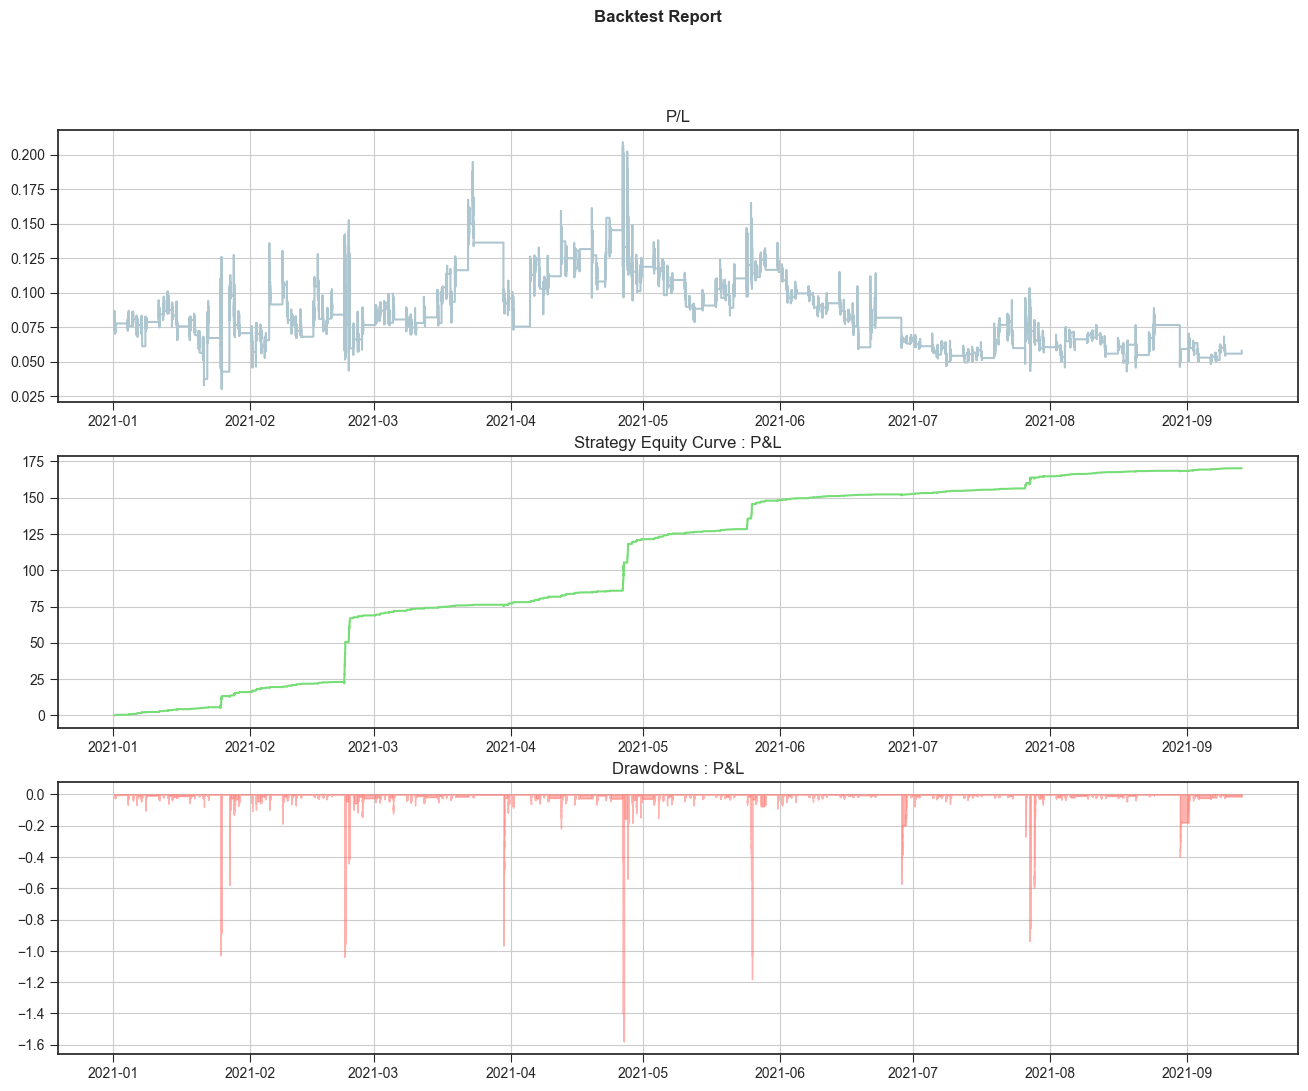

In [28]:
# initializing the strategy with 30 day lookback window 
# and 0.75 & 0.25 as the higher and lower quintile thresholds
strat = QuintileStrategy(ins, window_size=30, 
                         higher_quintile=0.75, 
                         lower_quintile=0.25)
# run the backtest
strat.run()
# get the backtest summary
strat.get_summary()

## Optimizing Quintile based Trading System

In [29]:
# In-sample optimization
opt = Optimizer(QuintileStrategy, ins)
# search paramters
params = {
    'lower_quintile': [0.01, 0.05, 0.1, 0.2, 0.25],
    'higher_quintile': [0.99, 0.95, 0.9, 0.8, 0.75]
}
# run search
opt.search(params)

  0%|          | 0/25 [00:00<?, ?it/s]

Best sharpe score achived : 6.5182129157729065

Best parameters for the above score : {'lower_quintile': 0.1, 'higher_quintile': 0.99}


#### Out of Sample performance

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :               136.73
      Sharpe Ratio :                 7.75
  Max. Drawdown P&L:                -1.06


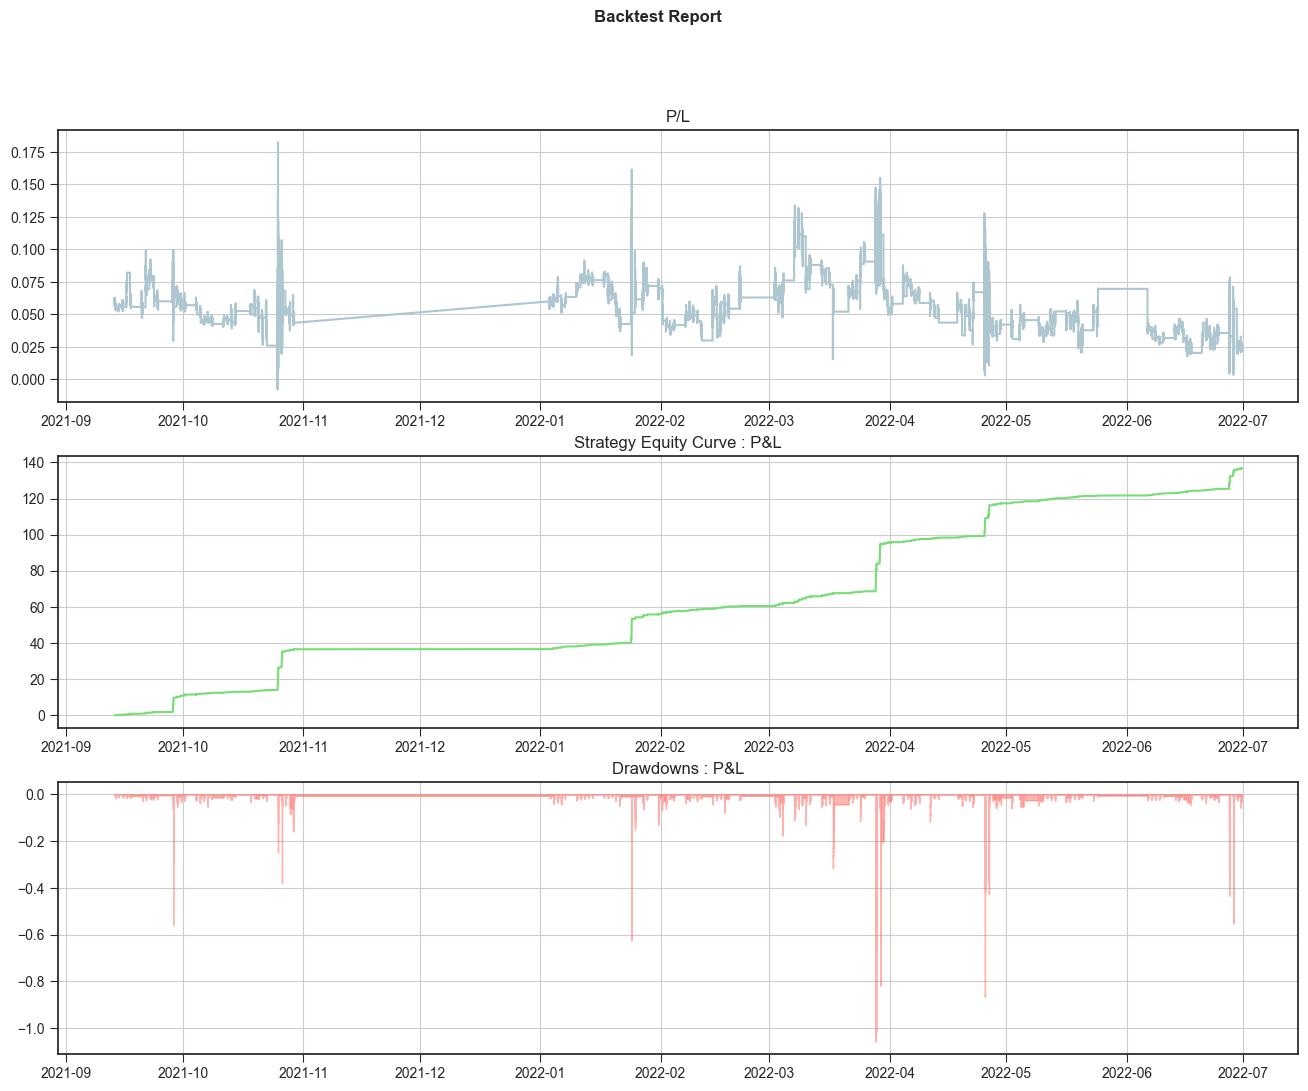

In [31]:
# initializing the strategy with 30 day lookback window 
strat = QuintileStrategy(oos, window_size=30, 
                         higher_quintile=0.99, 
                         lower_quintile=0.1)
# run the backtest
strat.run()
# get the backtest summary
strat.get_summary()

# Results

Comparing the Quintile based trading system with our benchmark trading strategy (Z-score based)
### In-sample Performance
| Comparision Metric| Quintile Strategy | Z-Score Stategy |
| :---------------- | :------: | ----: |
| Absolute P&L      | 170.29   | 91.73|
| Shape Ratio       |   5.56   | 3.76 |
| Maximum Drawdown  |  -1.58   | -1.69 |

### Out-of-sample Performance

| Comparision Metric| Quintile Strategy | Z-Score Stategy |
| :---------------- | :------: | ----: |
| Absolute P&L      | 136.73   | 161.28|
| Shape Ratio       |   7.75   | 6.64 |
| Maximum Drawdown  |  -1.06   | -1.94 |

# Conclusion

From the above results we can concluded that overall the **Qunitle based trading system performed much better than the Z-Score based trading system** both in-sample and out-of-sample. Althought the absolute P&L of the Quintile based strategy was slightly lower then the Z-Score based strategy during out-of-sample test, but the risk metrics (higher Sharpe ratio and lower Maximum drawdown) for the Quintile strategy seems to better.

# Future Work
- Improve the accuracy of the backtest results by implementing transaction cost, commissions and slippage.
- Use an Event Driven Backtesting methodology for emulating real market scenarios with less assumptions like immediate execution for both the assets.
- Develop a improved strategy to forecast the spread n-steps ahead and take trading decision based on it, rather than fixed threshold based system.